In [1]:
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from tqdm.notebook import tqdm
from openpyxl import Workbook, load_workbook

2024-08-01 21:32:56.470154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dropout_rate"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

c
def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    fun1 = trial.suggest_categorical("activation function", ["tanh", "linear"])
    window_size = trial.suggest_int("window_size", 1, 4)
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dropout_rate": trial.suggest_float("dr", 0.0, 0.5, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    pid_x, pid_y = data_to_X_Y(pid11[:,1:], window_size)
    pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], window_size)
    pid_xfull = np.vstack([pid_x, pid_x2])
    pid_yfull = np.concatenate([pid_y, pid_y2])
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.25, batch_size=64, epochs=40, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(pid_xfull)), pid_yfull)
    offline_score = get_offline_error(window_size, tuna_model)
    try:
        wb = load_workbook(filename)
        ws = wb.active
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "GRU"
        ws.append(list(tuna_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [3]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

pid11 = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")
pid12 = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.77500000e+00 5.44125438e-03 6.05768729e+00]
max_vals:[23.325       4.96735564  9.44468317]
DATA LOADED


In [4]:
minimal_params = {
    "n_hdden":1,
    "activation function": "tanh",
    "l1":1e-9,
    "l2":1e-9,
    "dr":0.1,
    "window_size":1
}

In [9]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
        print("STUDY LOADED")
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    
#study.optimize(tuna_obj, timeout=60*15) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

STUDY LOADED


In [13]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

del(best_model)
best_model = keras.models.load_model("models/best_model.keras")

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

NameError: name 'best_trial' is not defined

In [15]:
dt = 0.5
k = best_params["window_size"]
test = dataset_test[200:500]
#t_sim = np.arange(0, 200, dt)
t_sim = t2[200:500]

#X_off = np.zeros((t_sim.shape[0], 2))
#U_off = np.zeros((t_sim.shape[0], 2))
#Y_off = np.zeros(t_sim.shape[0])
Y_off = test[:, -1]
Y_pred = np.empty(t_sim.shape[0])

#X_off[0, :] = [Wa, Wb]
#Y_off[0] = y_f(X_off[0], x0=7.0)
Y_pred[0] = Y_off[0]
#U_off[:, :] = [u1ss, u2ss]
U_off = test[:, :-1]

#for n in range(0, t_sim.shape[0] - 1):
#    X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
#    Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])

Y_pred[: k + 1] = Y_off[: k + 1]

for n in tqdm(range(k, t_sim.shape[0] - 1)):
    data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
    model_input = pre(data_input.reshape(-1, k, 3))
    Y_pred[n + 1] = float(best_model.predict(model_input, verbose=0)[0,0])

  0%|          | 0/295 [00:00<?, ?it/s]

0.004937574494091888


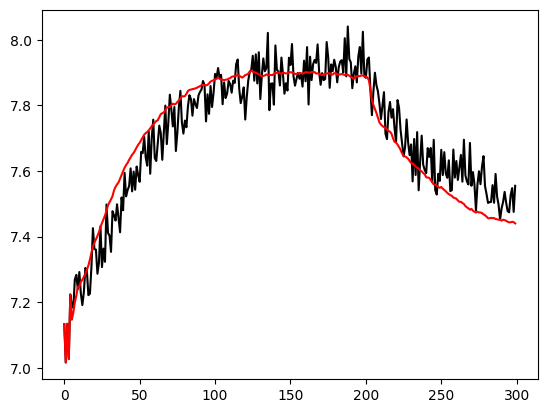

In [22]:
print(mse(Y_off, Y_pred))
plt.plot(Y_off, c='k')
plt.plot(Y_pred, c='r')
np.savetxt("results/GRU/offline.csv",np.column_stack((Y_off, Y_pred)), delimiter=",")

In [9]:
print(pre)

min_vals:[7.77500000e+00 5.44125438e-03 6.05768729e+00]
max_vals:[23.325       4.96735564  9.44468317]


In [10]:
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)

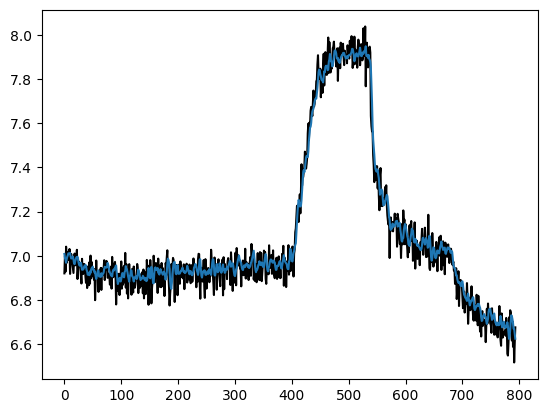

In [11]:
pid_x, pid_y = data_to_X_Y(pid11[:,1:], k)
pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], k)
pid_xfull = np.vstack([pid_x, pid_x2])
pid_yfull = np.concatenate([pid_y, pid_y2])

plt.plot(pid_yfull, c='k')
plt.plot(best_model(pre(pid_xfull)))

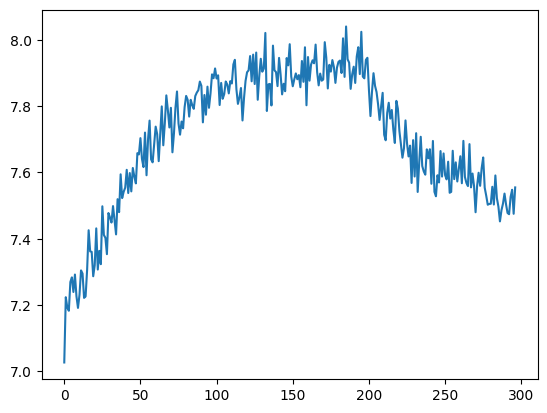

In [82]:
xtest, ytest = data_to_X_Y(test, window_size=k)

plt.plot(ytest)

In [88]:
ytest.shape

(297,)